<a href="https://colab.research.google.com/github/Abugahh/inpainting_model/blob/main/inpainting_modelv1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Understand Inpainting

Inpainting is the process of reconstructing lost or deteriorated parts of images. It can be used to remove objects or fill in parts of an image based on surrounding content.

In [ ]:
# # Load model directly
# from transformers import AutoModel
# model = AutoModel.from_pretrained("deepseek-ai/Janus-1.3B")

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json:   0%|          | 0.00/1.45k [00:00<?, ?B/s]

ValueError: The checkpoint you are trying to load has model type `multi_modality` but Transformers does not recognize this architecture. This could be because of an issue with the checkpoint, or because your version of Transformers is out of date.

Okay, let's address your question about from janus.models import MultiModalityCausalLM, VLChatProcessor and the extra contents within the janus/models directory in the repository.

You are correct in your understanding. When you execute the line from janus.models import MultiModalityCausalLM, VLChatProcessor, you are essentially importing the MultiModalityCausalLM and VLChatProcessor classes (or objects) that are defined within the janus.models module.

And yes, since you've cloned the Janus repository and installed the package locally using !pip install -e ., you are indeed loading the models (or rather, their definitions) from the local repository.

Let's elaborate on this further:

    janus.models: This refers to the models module, which is likely a Python file named models.py (or possibly a directory containing multiple files) located within the janus subdirectory of your cloned repository.

    MultiModalityCausalLM and VLChatProcessor: These are likely classes (or objects) defined within the models.py file. They represent specific functionalities or components related to the Janus model.

    Importing: When you use the from ... import ... statement, you are telling Python to:
        Find the janus package.        Within the janus package, find the models module.
        And from that module, import the specific objects or classes named MultiModalityCausalLM and VLChatProcessor.

    Loading from the Repo: Since you've installed the package using !pip install -e . from the local repository, Python knows to look for the janus package and its contents within the directory where you cloned the repository. Thus, when you import janus.models, it loads the definitions for MultiModalityCausalLM and VLChatProcessor from the models.py file (or equivalent) within your local Janus repository.

In essence: You're loading the code (definitions and implementations) for MultiModalityCausalLM and VLChatProcessor from the files within the janus/models directory of your local repository, allowing you to use these components in your code.

The extra files and code within the janus/models directory likely provide supporting functionality, helper classes, configurations, or other components that are required for MultiModalityCausalLM and VLChatProcessor to function correctly. They form the internal workings of the Janus model that you're using.


pip install -e menns install it in editable format

In [ ]:
!git clone https://github.com/deepseek-ai/Janus.git

%cd Janus

!pip install -e .
!pip install flash-attn
# !pip install streamlit

Cloning into 'Janus'...
remote: Enumerating objects: 118, done.
remote: Counting objects: 100% (72/72), done.
remote: Compressing objects: 100% (36/36), done.
remote: Total 118 (delta 50), reused 36 (delta 36), pack-reused 46 (from 1)
Receiving objects: 100% (118/118), 7.18 MiB | 30.65 MiB/s, done.
Resolving deltas: 100% (56/56), done.
/content/Janus
Obtaining file:///content/Janus
  Installing build dependencies ... done
  Checking if build backend supports build_editable ... done
  Getting requirements to build editable ... done
  Preparing editable metadata (pyproject.toml) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.8/50.8 kB 2.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.4/2.4 MB 32.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 43.2/43.2 kB 3.8 MB/s eta 0:00:00
  Building editable for janus (pyproject.toml) ... done
  Created wheel for janus: filename=janus-1.0.0-0.editable-py3-none-any.whl size=15926 sha256=3ba6eb34e7a64735b9e2e7

In [ ]:
# Install missing libraries if needed (uncomment and run if required)
!pip install torch transformers pillow numpy

import torch
import numpy as np
from transformers import AutoConfig, AutoModelForCausalLM
from janus.models import MultiModalityCausalLM, VLChatProcessor
from PIL import Image
import matplotlib.pyplot as plt


/usr/local/lib/python3.11/dist-packages/torch_xla/__init__.py:253: UserWarning: `tensorflow` can conflict with `torch-xla`. Prefer `tensorflow-cpu` when using PyTorch/XLA. To silence this warning, `pip uninstall -y tensorflow && pip install tensorflow-cpu`. If you are in a notebook environment such as Colab or Kaggle, restart your notebook runtime afterwards.
  warnings.warn(


Python version is above 3.10, patching the collections module.


/usr/local/lib/python3.11/dist-packages/transformers/models/auto/image_processing_auto.py:524: FutureWarning: The image_processor_class argument is deprecated and will be removed in v4.42. Please use `slow_image_processor_class`, or `fast_image_processor_class` instead
  warnings.warn(


 Load the Janus Model & Processor

Now, we load Janus and the chat processor to handle images & text.

In [ ]:
# Define function to load Janus model
def load_janus(model_name="deepseek-ai/Janus-1.3B"):
    config = AutoConfig.from_pretrained(model_name)
    language_config = config.language_config
    language_config._attn_implementation = 'eager'

    # Load the Janus AI model
    janus_model = AutoModelForCausalLM.from_pretrained(
        model_name,
        language_config=language_config,
        trust_remote_code=True
    )

    # Move model to GPU if available
    device = 'cuda' if torch.cuda.is_available() else 'cpu'
    janus_model = janus_model.to(device)

     # Cast model parameters to BFloat16 to match input type
    janus_model = janus_model.to(torch.bfloat16)

    # Load image & text processor
    janus_processor = VLChatProcessor.from_pretrained(model_name)

    return janus_model, janus_processor, device

# Load model & processor
janus_model, janus_processor, device = load_janus()


/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json:   0%|          | 0.00/1.45k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/4.18G [00:00<?, ?B/s]

preprocessor_config.json:   0%|          | 0.00/346 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/106k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/4.72M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/133 [00:00<?, ?B/s]

You are using the default legacy behaviour of the <class 'transformers.models.llama.tokenization_llama_fast.LlamaTokenizerFast'>. This is expected, and simply means that the `legacy` (previous) behavior will be used so nothing changes for you. If you want to use the new behaviour, set `legacy=False`. This should only be set if you understand what it means, and thoroughly read the reason why this was added as explained in https://github.com/huggingface/transformers/pull/24565 - if you loaded a llama tokenizer from a GGUF file you can ignore this message.


processor_config.json:   0%|          | 0.00/214 [00:00<?, ?B/s]

Some kwargs in processor config are unused and will not have any effect: add_special_token, image_tag, ignore_id, sft_format, num_image_tokens, mask_prompt. 


Add image tag = <image_placeholder> to the tokenizer


In [ ]:
# # Define function to load Janus model
# def load_janus(model_name="deepseek-ai/Janus-1.3B"):
#     config = AutoConfig.from_pretrained(model_name)
#     language_config = config.language_config
#     language_config._attn_implementation = 'eager'

#     # Load the Janus AI model
#     janus_model = AutoModelForCausalLM.from_pretrained(
#         model_name,
#         language_config=language_config,
#         trust_remote_code=True
#     )

#     # Move model to GPU if available
#     device = 'cuda' if torch.cuda.is_available() else 'cpu'
#     janus_model = janus_model.to(device)

#     # Cast model parameters to BFloat16 to match input type
#     janus_model = janus_model.to(torch.bfloat16)

#     # Load image & text processor
#     janus_processor = VLChatProcessor.from_pretrained(model_name)

#     return janus_model, janus_processor, device

# # Load model & processor
# janus_model, janus_processor, device = load_janus()

OutOfMemoryError: CUDA out of memory. Tried to allocate 44.00 MiB. GPU 0 has a total capacity of 14.74 GiB of which 34.12 MiB is free. Process 12690 has 14.71 GiB memory in use. Of the allocated memory 14.56 GiB is allocated by PyTorch, and 50.83 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)

In [ ]:
# Load an Input Image (Empty Apartment)

# We now load an image of an empty apartment.

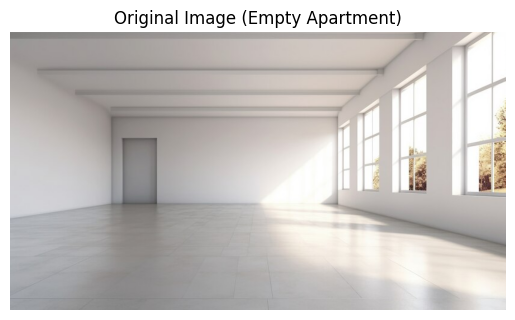

In [ ]:
# Load an image (change file path to your image)
image_path = "/content/livingroom.jpg"  # Replace with your file
input_image = Image.open(image_path).convert("RGB")

# Display the original image
plt.imshow(input_image)
plt.axis("off")
plt.title("Original Image (Empty Apartment)")
plt.show()


In [ ]:
@torch.inference_mode()
def modify_image(image, prompt, temperature=0.7, guidance=5):
    """Modify an image using Janus based on a text prompt."""

    # Clear GPU cache if available
    if torch.cuda.is_available():
        torch.cuda.empty_cache()

    # Prepare the conversation format
    conversation = [
        {"role": "User", "content": f"<image_placeholder>\n{prompt}", "images": [image]},
        {"role": "Assistant", "content": ""},
    ]

    # Process input image
    processed_inputs = janus_processor(
        conversations=conversation, images=[image], force_batchify=True
    ).to(device)

    # Generate image modification
    inputs_embeds = janus_model.prepare_inputs_embeds(**processed_inputs)

    outputs = janus_model.language_model.generate(
        inputs_embeds=inputs_embeds,
        attention_mask=processed_inputs.attention_mask,
        max_new_tokens=512,
        do_sample=(temperature > 0),
        temperature=temperature,
        pad_token_id=janus_processor.tokenizer.eos_token_id
    )

    # Decode the AI response
    modified_description = janus_processor.tokenizer.decode(outputs[0].cpu().tolist(), skip_special_tokens=True)

    return modified_description


In [ ]:
# Define a text prompt for modifying the image
prompt = "Furnish this apartment in a Scandinavian style with modern wooden furniture and soft warm lighting."

# Run inpainting (modification) function
modified_description = modify_image(input_image, prompt)

# Show result
print("Janus AI's Response:", modified_description)


Janus AI's Response: To furnish this apartment in a Scandinavian style with modern wooden furniture and soft warm lighting, you could consider the following:

### Furniture
1. **Wooden Coffee Table**:
   - **Material**: Light-colored wood (perhaps oak or birch) with a smooth finish.
   - **Size**: 120x60cm.

2. **Wooden Dining Table**:
   - **Material**: Similar to the coffee table, light-colored wood with a smooth finish.
   - **Size**: 90x60cm.

3. **Wooden Bookshelf**:
   - **Material**: Light-colored wood with a smooth finish.
   - **Size**: 40x60cm.

4. **Wooden Bookshelf for Display**:
   - **Material**: Light-colored wood with a smooth finish.
   - **Size**: 90x60cm.

5. **Wooden Accent Table**:
   - **Material**: Light-colored wood with a smooth finish.
   - **Size**: 30x60cm.

6. **Wooden Sofa**:
   - **Material**: Light-colored wood, possibly with metallic or leather accents.
   - **Size**: 150x150cm.

7. **Wooden Armchair**:
   - **Material**: Light-colored wood with a smoot

In [ ]:
# Define a text prompt for generating the image
prompt = "Furnish this apartment in a Scandinavian style with modern wooden furniture and soft warm lighting."

# Run image generation (instead of just text modification)
generated_image = generate_image(prompt)  # Make sure this function exists!

# Display the generated image
import matplotlib.pyplot as plt

plt.imshow(generated_image)
plt.axis("off")
plt.title("Generated Image (Furnished Apartment)")
plt.show()


AttributeError: 'int' object has no attribute 'update'

In [ ]:
@torch.inference_mode()
def generate_image(prompt):
    """Generate a new image based on a text prompt."""
    width, height = 512, 512  # Image size
    input_ids = torch.LongTensor(janus_processor.tokenizer.encode(prompt)).to(device)

    # Generate the image
    # Use janus_model.language_model.generate instead of janus_model.generate
    output, patches = janus_model.language_model.generate( # Changed line
        input_ids,
        width,
        height
    )

    # Convert to PIL image
    images = unpack(patches, width, height)
    new_image = Image.fromarray(images[0])

    return new_image

In [ ]:
# Display the generated image
plt.imshow(generated_image)
plt.axis("off")  # Hides axes for a cleaner display
plt.title("Generated Image (Furnished Apartment)")
plt.show()


NameError: name 'generated_image' is not defined